In [2]:
import nmslib
exec(open("../database.py").read())
exec(open("../helperFunctions.py").read())
import numpy as np
from keras.datasets import mnist
from time import perf_counter
from ast import literal_eval

Your CPU supports instructions that this binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2
For maximum performance, you can install NMSLIB from sources 
pip install --no-binary :all: nmslib
2024-03-08 10:07:11.998782: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-08 10:07:11.998805: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-08 10:07:11.999467: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-08 10:07:12.003482: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance

In [3]:
name = 'mnist-784'
runs = 1
metric = 'euclidean'
queries = 1000
nameFull = name + '-' + metric + '-true-labels.xlsx'
datasetTrainImages, datasetTestImages, _ = get_ann_benchmark_data(name)

trainDataset :  (60000, 784)
testDataset :  (10000, 784)


***Create Nmslib Index***

In [4]:
def createIndex(indexMethod, datasetImages):
    f = datasetImages.shape[1] # Length of item vector that will be indexed
    index = indexMethod(method='hnsw', space='l2')
    time_start = perf_counter()
    index.addDataPointBatch(datasetImages)
    index.createIndex({'post': 2}, print_progress=True)
    time_end = perf_counter()
    totalTime = (time_end - time_start)
    return (index, totalTime)


0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

Took 17.992 seconds


In [5]:
(minBuildTime, maxBuildTime, indexedStruct) = createIndexNumerous(createIndex, nmslib.init, datasetTrainImages, runs)
print('minBuildTime : ', minBuildTime)
print('maxBuildTime : ', maxBuildTime)

In [17]:
def measureTime(par, indexes, distances, datasetTestImages):
    totalTime = 0
    for i in range(par) : 
        time_start = perf_counter()
        index, distance = indexedStruct.knnQuery(datasetTestImages[i], k=100)
        time_end = perf_counter()
        totalTime += (time_end - time_start)
        indexes.append(index)
        distances.append(np.sqrt(distance))
    return np.round(totalTime, 3)

Took 0.198 seconds


0.198

In [18]:
(minSearchTime, maxSearchTime, indexes, distances) = measureTimeNumerous(measureTime, runs, queries, datasetTestImages)
print('minSearchTime : ', minSearchTime)
print('maxSearchTime : ', maxSearchTime)

In [19]:
indexes = np.array(indexes)
distances = np.round(np.array(distances).astype(float), 4)

In [20]:
print('indexes : ', indexes.shape)
print('distances : ', distances.shape)

indexes :  (1000, 100)
distances :  (1000, 100)


In [21]:
path = '../datasets/'+nameFull
(trueIndexes, trueDistances) = readDB(path)

trueIndexes :  (1000, 100)
trueDistances :  (1000, 100)


In [22]:
amount = 10
compareElems(amount, indexes, distances, trueIndexes, trueDistances)

53843 || 53843
676.584 || 676.584
38620 || 38620
793.9868 || 793.9868
16186 || 16186
862.6766 || 862.6766
27059 || 27059
864.5039 || 864.5039
47003 || 47003
894.7 || 894.7
14563 || 14563
909.7043 || 909.7043
44566 || 44566
917.6323 || 917.6323
15260 || 15260
921.6241 || 921.6241
40368 || 40368
922.147 || 922.147
36395 || 36395
943.4972 || 943.4972


In [23]:
calculateRecallAverage(indexes, distances, trueIndexes, trueDistances)
calculateRecallAverage(indexes, distances, trueIndexes, trueDistances, 1.01)
calculateRecallAverage(indexes, distances, trueIndexes, trueDistances, 1.1)

0.3627
0.8459
1.0000


In [24]:
print(indexes[0]) # will find the 100 nearest neighbors

[53843 38620 16186 27059 47003 14563 44566 15260 40368 36395 30502 14770
 17228 35919 27166 21518 52010 38763 14505 48108  9444 55668  9724 57204
 17946 41958 40710 29762 26957 24700 54364 35937 41236 23149 31073 51420
  1673 50255  4130 30988 32980 25972 38504 25705 29983 59665 43917 15856
 39003  6475  3298 35150 47117 53679 31614 22546 50147 49516  6525 47015
 53589 13382 37550 55750 51500 58507 26967 42146 51916 32432 16935 48955
 53855 17017  3324 46160 41928   773 53483 21463 58009 23969 31882  9793
 24572 27005 52606 53333 18429  1789 11421 25788 53418  8931 49024 35965
 30722 24907   522 58526]


index :  53843 
distance :  676.584
index :  38620 
distance :  793.9868
index :  16186 
distance :  862.6766
index :  27059 
distance :  864.5039
index :  47003 
distance :  894.7
index :  14563 
distance :  909.7043
index :  44566 
distance :  917.6323
index :  15260 
distance :  921.6241
index :  40368 
distance :  922.147
index :  36395 
distance :  943.4972


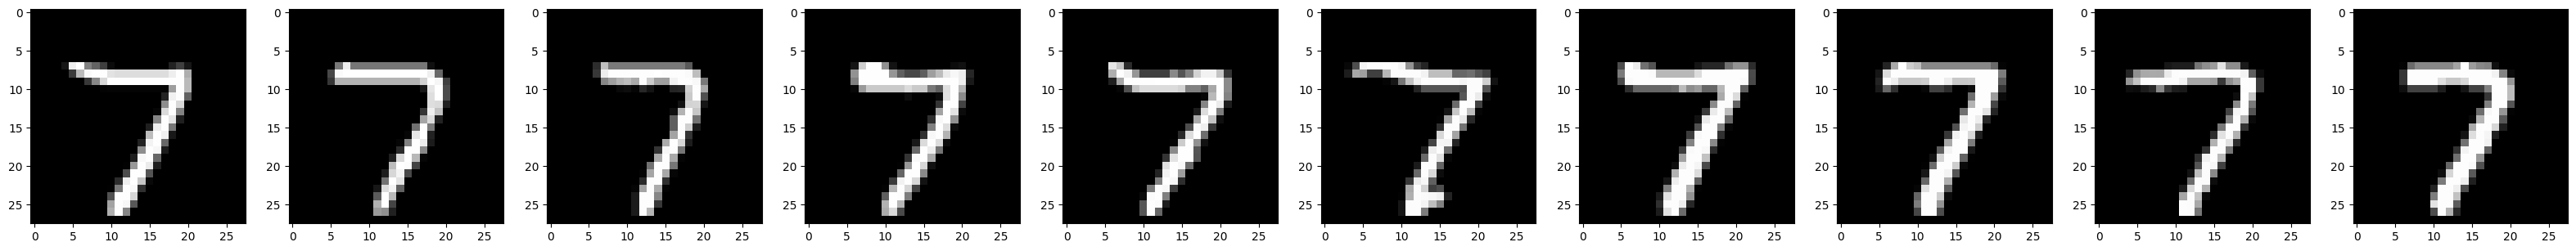

In [25]:
draw_mnist(indexes, distances, datasetTrainImages)